## Retinal image recognition - PROJECT
#### By Fedi and Julien

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
from skimage.util import random_noise
from scipy.ndimage import gaussian_filter
from skimage import filters
import skimage
import scipy

### Loading retinal image

In [2]:
retinal_img_bgr = cv2.imread("datasets/training/images/21_training.tif")
retinal_img_rgb = cv2.cvtColor(retinal_img_bgr, cv2.COLOR_BGR2RGB)
retinal_img_rgb.shape

(584, 565, 3)

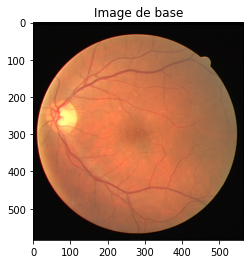

In [22]:
plt.imshow(retinal_img_rgb)
plt.title("Image de base")
plt.show()

In [4]:
# Take the green chanel in a 2d img
green_ret = retinal_img_rgb.copy()
green_ret[:,:,0] = 0
green_ret[:,:,2] = 0

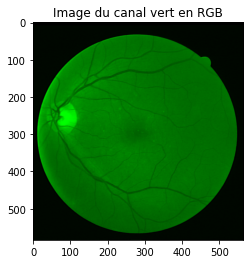

In [23]:
plt.imshow(green_ret)
plt.title("Image du canal vert en RGB")
plt.show()

In [6]:
# Convert from RGB to grayscale image
retinal_img = green_ret[:,:,1]
retinal_img.shape

(584, 565)

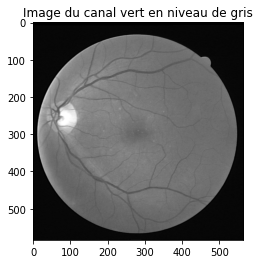

In [24]:
plt.imshow(retinal_img, cmap='gray')
plt.title("Image du canal vert en niveau de gris")
plt.show()

### Gaussian filter and Canny Edge Detector

This steps uses the cv2.Canny function that implement itself a filter and a binarization process.

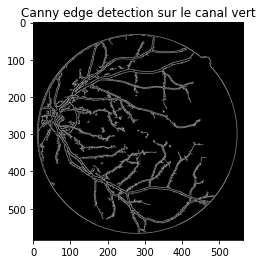

In [25]:
edges = cv2.Canny(retinal_img,20,60, apertureSize =3, L2gradient = True)
plt.imshow(edges, cmap='gray')
plt.title("Canny edge detection sur le canal vert")
plt.show()

### Dilatation

We use dilatation to fill the blank between 2 borders of a blood vessel

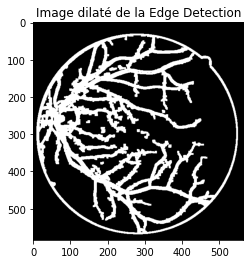

In [28]:
kernel = np.ones((3,3), np.uint8)
img_dilation = cv2.dilate(edges, kernel, iterations=2) / 255
plt.imshow(img_dilation, cmap='gray')
plt.title("Image dilaté de la Edge Detection")
plt.show()

### Squelettisation-Hilditch

We transform our segmentation to a skeleton

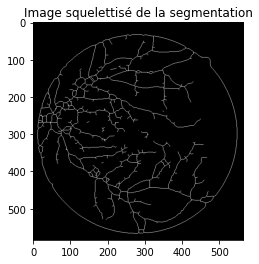

In [29]:
from skimage.morphology import skeletonize, remove_small_objects
skeleton = skeletonize(img_dilation)
plt.imshow(skeleton, cmap='gray')
plt.title("Image squelettisé de la segmentation")
plt.show()

### Deleting the minor regions

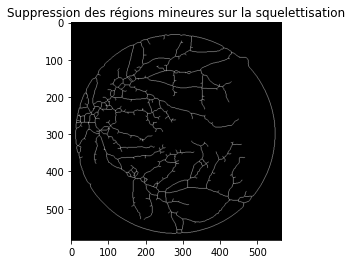

In [30]:
# This delete non connected regions to the global blood vessels network
skeleton_processed = remove_small_objects(skeleton, min_size=40, connectivity=40).astype(int)
plt.imshow(skeleton_processed, cmap='gray')
plt.title("Suppression des régions mineures sur la squelettisation")
plt.show()

### Crossing number

In [105]:
# Function to determine type of minutiae at pixel P(i,j)

def crossing_number(img):
    # Neighbors list position
    cells = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]
    # List of ending and bifurcation
    ending_list = []
    bifurcation_list = []
    # For each pixel (with a stride of 2 to avoid border problem) we look at the value of its neighbors
    for i in range(1,img.shape[0]-2):
        for j in range(1,img.shape[1]-2):
            neigh_values = [img[i + k][j + l] for k, l in cells]           
            # Compute de "crossing" value to l
            crossings = 0
            for m in range(0, 8):
                crossings += abs(neigh_values[m] - neigh_values[m + 1])
            crossings /= 2
            # Append the coordinate of ending or bifurcation pixel
            if skeleton_processed[i,j] == 1:
                if crossings == 1:
                    ending_list.append([i,j])
                if crossings == 3:
                    bifurcation_list.append([i,j])
    return np.array(ending_list), np.array(bifurcation_list)

### Minutiae's coordinates over the skeleton images

In [103]:
ending_list, bifurcation_list = crossing_number(skeleton_processed)

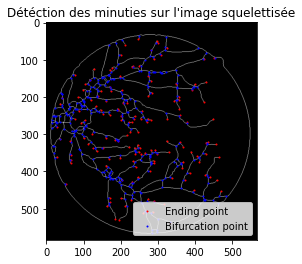

In [104]:
# Plot the minutiae over the skeleton image
plt.imshow(skeleton_processed, cmap='gray')
plt.scatter(ending_list[:, 1], ending_list[:, 0], marker=".", color="red", s=4, label="Ending point")
plt.scatter(bifurcation_list[:, 1], bifurcation_list[:, 0], marker=".", color="blue", s=4, label="Bifurcation point")
plt.legend(loc='best')
plt.title("Détéction des minuties sur l'image squelettisée")
plt.show()

### Minutiae's map

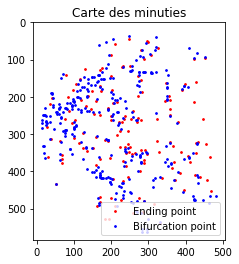

In [45]:
fig = plt.figure()
ax = fig.add_subplot()
# Square plot
ax.set_aspect('equal', adjustable='box')

# Scatter plot of the 2 lists
plt.scatter(ending_list[:, 1], ending_list[:, 0], marker="o", color="red", s=3, label="Ending point")
plt.scatter(bifurcation_list[:, 1], bifurcation_list[:, 0], marker="o", color="blue", s=3, label="Bifurcation point")
ax.invert_yaxis()
plt.ylim([skeleton_processed.shape[0],0])
plt.legend(loc='best')
plt.title('Carte des minuties')
plt.show()

### Look at the precision compared to the truth mask

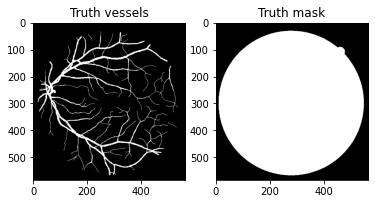

In [97]:
import imageio
# Load the truth mask
img_true = imageio.mimread("datasets/training/1st_manual/21_manual1.gif")[0] /255
img_mask = imageio.mimread("datasets/training/mask/21_training_mask.gif")[0] /255
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img_true, cmap='gray')
ax1.set_title('Truth vessels')
ax2.imshow(img_mask, cmap='gray')
ax2.set_title('Truth mask')
plt.show()

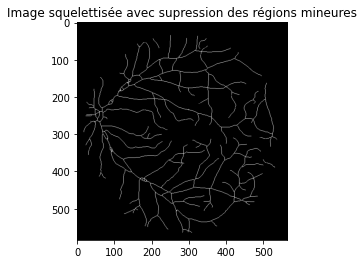

In [98]:
skeleton_true = skeletonize(img_true)
skeleton_true = skeleton_true.astype(int)
plt.imshow(skeleton_true, cmap='gray', interpolation = None)
plt.title('Image squelettisée avec supression des régions mineures')
plt.show()

In [100]:
ending_list_true, bifurcation_list_true = crossing_number(skeleton_true)

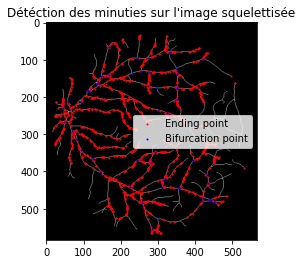

In [101]:
plt.imshow(skeleton_true, cmap='gray', interpolation=None)
plt.scatter(ending_list_true[:, 1], ending_list_true[:, 0], marker=".", color="red", s=4, label="Ending point")
plt.scatter(bifurcation_list_true[:, 1], bifurcation_list_true[:, 0], marker=".", color="blue", s=4, label="Bifurcation point")
plt.legend(loc='best')
plt.title("Détéction des minuties sur l'image squelettisée")
plt.show()

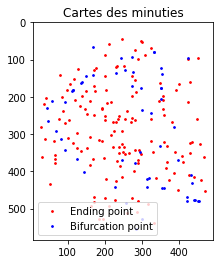

In [106]:
fig = plt.figure()
ax = fig.add_subplot()
# Square plot
ax.set_aspect('equal', adjustable='box')

plt.scatter(ending_list[:, 1], ending_list[:, 0], marker="o", color="red", s=3, label="Ending point")
plt.scatter(bifurcation_list_true[:, 1], bifurcation_list_true[:, 0], marker="o", color="blue", s=3, label="Bifurcation point")
ax.invert_yaxis()
plt.ylim([skeleton_true.shape[0],0])
plt.legend(loc='best')
plt.title("Cartes des minuties")
plt.show()